In [93]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Declaração de variáveis


In [94]:
num_cobaias = 9
num_pics = 10
input_img = Image.open("database/p6_resized/p6_reconhecimento.jpeg").convert('L')


### Conversão das imagens para formação de uma base


In [95]:
base = [Image.open(f'database/p{i}_resized/p{i}_{j}.jpeg').convert('L') for i in range(1, num_cobaias+1) for j in range(1, num_pics+1)]
size = len(base)
X = np.array([base[i].getdata() for i in range(size)])
len(X[0])

10800

### Centrar os dados na média


In [96]:
media = np.mean(X, 0)
phi = X-media

### Cara média


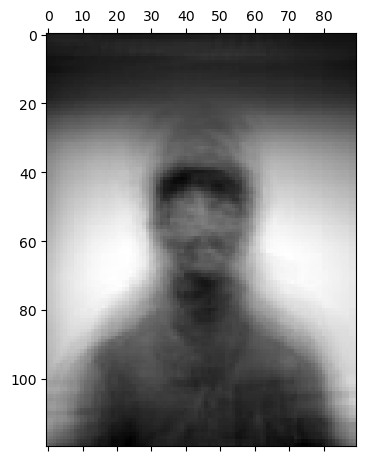

In [102]:
display(plt.matshow(np.reshape(media, (120, 90)), cmap='gray'))

### Aplicar SVD


In [105]:
e_faces, sigma, v = np.linalg.svd(phi.transpose(), full_matrices=False)
val_prop = sigma*sigma
traco = sum(val_prop)